In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [8]:
from itertools import chain

import re
import utils

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## 基于人民日报语料和CRF模型构建一个中文NER系统

选取了1998年1月的人民日报语料，采用了7：3的训练-测试集划分。

初步处理语料之后，数据格式如下所示。

In [9]:
corpus_filepath = "data/199801-raw.txt"
processed_corpus = utils.data_processing(corpus_filepath)
processed_corpus[1:3]

[['中共中央/nt', '总书记/n', '、/w', '国家/n', '主席/n', '江泽民/nr'],
 ['(/w', '一九九七年十二月三十一日/t', ')/w']]

## 特征

采用$\left \{ w_{-1}, w_0, w_{+1}, w_{-1}w_0, w_0w_{+1} \right \}$的模板提取特征。




In [10]:
def load_corpus(path):
    processed_corpus = utils.data_processing(path)
    sequences = utils.init_sequence(processed_corpus)
    word_seqs = sequences[0]
    position_seqs = sequences[1]
    tag_seqs = sequences[2]
    model_input = utils.get_model_input(word_seqs)
    
    x_train, x_test, y_train, y_test = train_test_split(model_input, tag_seqs, test_size=0.3, random_state=42, shuffle=True)
    return x_train, x_test, y_train, y_test

# corpus_filepath = "data/199801-raw.txt"
x_train, x_test, y_train, y_test = load_corpus(corpus_filepath)

In [11]:
x_train[17]

[{'w-1': '<BOS>',
  'w': '(',
  'w+1': '蒋',
  'w-1_w': '<BOS>(',
  'w_w+1': '(蒋',
  'bias': 1.0},
 {'w-1': '(', 'w': '蒋', 'w+1': '必', 'w-1_w': '(蒋', 'w_w+1': '蒋必', 'bias': 1.0},
 {'w-1': '蒋', 'w': '必', 'w+1': '达', 'w-1_w': '蒋必', 'w_w+1': '必达', 'bias': 1.0},
 {'w-1': '必', 'w': '达', 'w+1': ')', 'w-1_w': '必达', 'w_w+1': '达)', 'bias': 1.0},
 {'w-1': '达',
  'w': ')',
  'w+1': '<EOS>',
  'w-1_w': '达)',
  'w_w+1': ')<EOS>',
  'bias': 1.0}]

## 模型训练

调用sklearn-crfsuite库实现crf模型的定义，学习算法选择默认的L-BFGS算法。

In [12]:
model = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.2, 
    max_iterations=90, 
    all_possible_transitions=True
)

model.fit(x_train, y_train)

/home/y212202031/.conda/envs/lium_torch/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.2,
    keep_tempfiles=None, max_iterations=90)

## 模型评估

In [13]:
labels = list(model.classes_)
labels.remove('O')
labels

['B_PER', 'I_PER', 'B_T', 'I_T', 'B_LOC', 'I_LOC', 'B_ORG', 'I_ORG']

In [14]:
y_predict = model.predict(x_test)
sorted_labels = sorted(
    labels, key=lambda BIO_tag: (BIO_tag[1:], BIO_tag[0])
)

print(metrics.flat_classification_report(y_true=y_test, y_pred=y_predict, labels=sorted_labels, digits=3))

/home/y212202031/.conda/envs/lium_torch/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B_LOC', 'I_LOC', 'B_ORG', 'I_ORG', 'B_PER', 'I_PER', 'B_T', 'I_T'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

       B_LOC      0.925     0.865     0.894      3206
       I_LOC      0.906     0.853     0.879     14866
       B_ORG      0.937     0.906     0.921      6584
       I_ORG      0.923     0.885     0.904     10583
       B_PER      0.963     0.907     0.934      6109
       I_PER      0.955     0.922     0.938     11553
         B_T      0.979     0.961     0.970      4882
         I_T      0.984     0.975     0.979     11543

   micro avg      0.944     0.908     0.926     69326
   macro avg      0.947     0.909     0.927     69326
weighted avg      0.944     0.908     0.925     69326



## 超参数搜索

之前定义CRF模型的时将$L1$和$L2$正则化项系数定义为0.1和0.2，下面用随机搜索和3-fold交叉验证寻找较优的正则化项参数。

In [15]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=30, 
                        scoring=f1_scorer)
                        
rs.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/y212202031/.conda/envs/lium_torch/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 49.5min finished


CPU times: user 49min 24s, sys: 30.9 s, total: 49min 54s
Wall time: 51min 7s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f925eec9ba8>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f925dce9128>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B_PER', 'I_PER', 'B_T', 'I_T', 'B_LOC', 'I_LOC', 'B_ORG', 'I_ORG']),
                   verbose=1)

最优结果：

In [16]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.05767215761851891, 'c2': 0.07709740059764503}
best CV score: 0.9167164012941867
model size: 5.61M


下面这张图展示了RandomizedSearchCV所搜索的``c1``和``c2``值，红色的散点意味着更好的结果，蓝色的结果更差。

可以看到其实图中的散点对应的平均测试得分都比较接近，$\min$和$\max$差距不大。

Dark blue => 0.8896, dark red => 0.9167


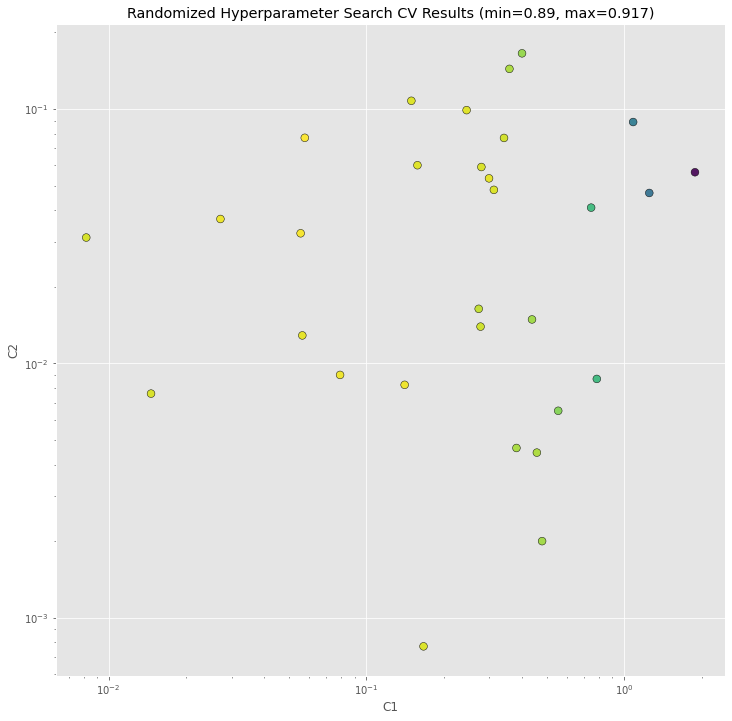

In [17]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

在本次实验的测试集上尝试搜索到的最优超参数，观察到变化不显著。

In [22]:
crf = rs.best_estimator_
y_pred = crf.predict(x_test)
print(metrics.flat_classification_report(y_true=y_test, y_pred=y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       B_LOC      0.926     0.857     0.890      3206
       I_LOC      0.912     0.839     0.874     14866
       B_ORG      0.935     0.910     0.922      6584
       I_ORG      0.920     0.889     0.904     10583
       B_PER      0.964     0.911     0.937      6109
       I_PER      0.956     0.923     0.939     11553
         B_T      0.979     0.961     0.970      4882
         I_T      0.985     0.974     0.979     11543

   micro avg      0.945     0.906     0.925     69326
   macro avg      0.947     0.908     0.927     69326
weighted avg      0.945     0.906     0.925     69326



## 模型学到了什么？

下面我们简单观察一下训练完的模型参数，是否能够有一些符合直觉和语言规则的表现。

### transition

In [27]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(12))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-12:])

Top likely transitions:
I_LOC  -> I_LOC   6.936293
B_LOC  -> I_LOC   6.180399
B_ORG  -> I_ORG   5.727910
B_PER  -> I_PER   5.217600
B_T    -> I_T     4.910737
O      -> O       4.484217
I_PER  -> I_PER   4.334841
I_ORG  -> I_ORG   4.158659
I_T    -> I_T     3.100000
O      -> B_T     0.835000
O      -> B_PER   0.789746
I_ORG  -> O       0.605403

Top unlikely transitions:
B_ORG  -> I_LOC   -4.918492
B_T    -> O       -5.035032
I_ORG  -> I_T     -5.100284
B_PER  -> B_PER   -5.152471
B_ORG  -> O       -5.204367
I_PER  -> I_T     -5.746436
O      -> I_PER   -5.936182
I_ORG  -> I_LOC   -6.288599
O      -> I_ORG   -6.602775
O      -> I_T     -6.888443
O      -> I_LOC   -6.996929
I_T    -> B_T     -8.387853


很明显，举例来说，如 Top likely transitions 的第二行：地名起始 token $B\_LOC$ 后面接着的很可能是地名的中间 token $I\_LOC$，同理如 Top unlikely transitions 的倒数第五行和倒数第二行，从其它标签的 token 转移到 $I\_LOC$ 的权重参数会受到惩罚。

### features

In [32]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(20))

Top positive:
11.064473 O        w:、
8.687785 B_PER    w:刘
8.217797 O        w:,
7.732534 O        w:的
7.640986 B_PER    w:吴
7.342371 O        w:。
6.571684 B_PER    w:袁
6.355836 O        w:与
6.342999 B_PER    w:郭
6.170374 O        w:对
6.169432 O        w_w+1:部门
6.100547 B_PER    w:崔
5.947073 B_PER    w:李
5.919781 I_T      w-1_w:晚上
5.877307 B_PER    w_w+1:江主
5.841035 B_PER    w:褚
5.808640 B_T      w:今
5.741757 B_PER    w_w+1:毛主
5.715439 B_PER    w:杨
5.660075 O        w:在


In [31]:
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-15:])


Top negative:
-3.722432 I_LOC    w-1:司
-3.748242 O        w:徐
-3.783653 O        w-1_w:共和
-3.808998 O        w:潘
-3.815857 O        w:朱
-3.853134 O        w-1_w:日本
-3.930380 I_ORG    w+1:队
-3.944700 I_LOC    w-1:厂
-4.029497 O        w:江
-4.182139 I_LOC    w-1:处
-4.451183 I_LOC    w-1:社
-4.472682 O        w:李
-4.573612 I_LOC    w-1:队
-4.946306 I_LOC    w-1:府
-4.961714 O        w:赵


可以观察到：
+ 对顿号（"、"）和句号（"。"），模型几乎可以断定它对应的标签是 $O$，这也是中文语料中模型很容易学习到的信息。
+ 对"刘"、"吴"、"李"这些人名的姓氏，模型倾向于将他们分配为人名实体的起始 $B\_PER$，或给这些 常用作姓氏的字 与 非实体标签$O$ 所组成的 pair 较大的惩罚。
+ 对 character bigram "晚上"，和时间实体标签中间 token $I\_T$ 组成的 pair 权重很高，也非常符合语言习惯，语料中存在大量的"今天晚上"、"明天晚上"或"某某日晚上"的片段。
+ 因为语料本身的特性，模型对"江主"这种从领导人称谓中提取的特征也很敏感。